# DCGAN - Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

# Abstract - arXiv.org
In recent years, supervised learning with convolutional networks (CNNs) has seen huge adoption in computer vision applications. Comparatively, unsupervised learning with CNNs has received less attention. In this work we hope to help bridge the gap between the success of CNNs for supervised learning and unsupervised learning. We introduce a class of CNNs called deep convolutional generative adversarial networks (DCGANs), that have certain architectural constraints, and demonstrate that they are a strong candidate for unsupervised learning. Training on various image datasets, we show convincing evidence that our deep convolutional adversarial pair learns a hierarchy of representations from object parts to scenes in both the generator and discriminator. Additionally, we use the learned features for novel tasks - demonstrating their applicability as general image representations.

# References
* [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks - arxiv.org](https://arxiv.org/abs/1511.06434)
* [Deep Convolutional Generative Adversarial Network - tensorflow.org](https://www.tensorflow.org/tutorials/generative/dcgan)
* [Deep Convolutional Generative Adversarial Network - github.com](https://github.com/look4pritam/kgan)



# Import TensorFlow 2.x.

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import numpy as np
np.random.seed(7)

print(tf.__version__)

2.2.0


# Process MNIST dataset.

### Load MNIST dataset.

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
image_shape = (train_images.shape[1], train_images.shape[2], 1)

### Reshape dataset images.

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

### Define buffer size and batch size.

In [5]:
buffer_size = 60000
batch_size = 256

### Create TensorFlow dataset.

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

# Create discriminator model.

In [8]:
discriminator = tf.keras.Sequential(name='discriminator')

discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_shape))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

# Create generator model.

In [7]:
latent_dimension = 100
noise_shape = (latent_dimension,)

In [9]:
generator_shape = (7, 7, 256)
generator_size = np.prod(generator_shape)

In [10]:
generator = tf.keras.Sequential(name='generator')

generator.add(layers.Dense(generator_size, use_bias=False, input_shape=noise_shape))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape(generator_shape))    

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0 

# Show generated image.

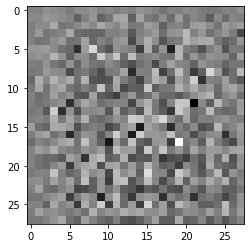

In [11]:
import matplotlib.pyplot as plot
from IPython import display

noise = tf.random.normal([1, latent_dimension])
generated_image = generator(noise, training=False)

plot.imshow(generated_image[0, :, :, 0], cmap='gray')

# Show discriminator prediction for generated image.

In [12]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00342712]], shape=(1, 1), dtype=float32)


# Define discriminator loss.

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def compute_discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define generator loss.

In [15]:
def compute_generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Create optimizer for discriminator and generator.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Plot generated images.

In [17]:
import matplotlib.pyplot as plot

def plot_generated(number_of_samples=10, dim=(1, 10), figsize=(12, 2)):

    noise = tf.random.normal([number_of_samples, latent_dimension])
    generated_images = generator.predict(noise)
    generated_images = generated_images*127.5 + 127.5
    generated_images = generated_images.reshape(number_of_samples, image_shape[0], image_shape[1])

    plot.figure(figsize=figsize)
    for i in range(number_of_samples):
        plot.subplot(dim[0], dim[1], i+1)
        plot.imshow(generated_images[i], cmap='gray')
        plot.axis('off')

    plot.tight_layout()
    plot.show()

# Train the model.

In [18]:
def train(dataset, epochs=100, plot_frequency=1):    
      
    for epoch in range(epochs):  

      for images in dataset:

        noise = tf.random.normal([batch_size, latent_dimension])  

        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
            generated_images = generator(noise, training=True)   

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            generator_loss = compute_generator_loss(fake_output)
            discriminator_loss = compute_discriminator_loss(real_output, fake_output)     

        gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
        gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      if (epoch > 0)  and (epoch%plot_frequency == 0):           
            plot_generated()

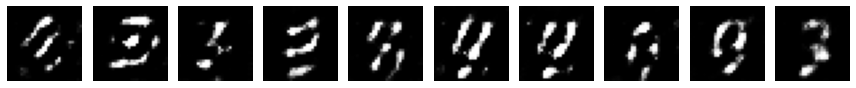

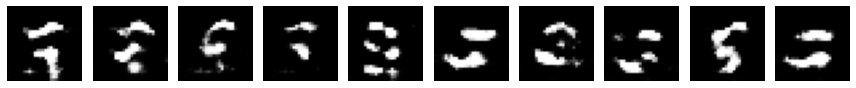

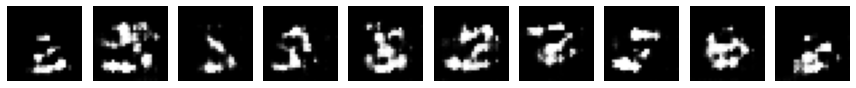

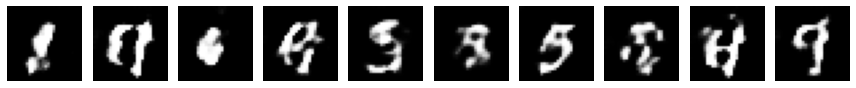

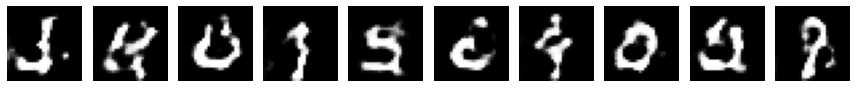

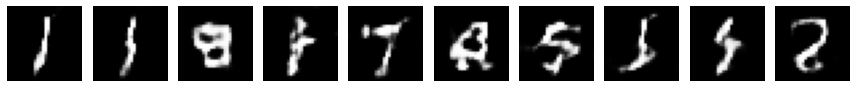

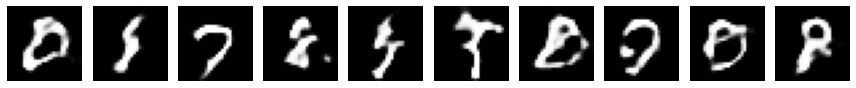

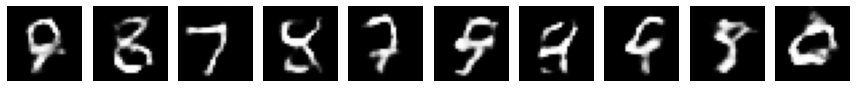

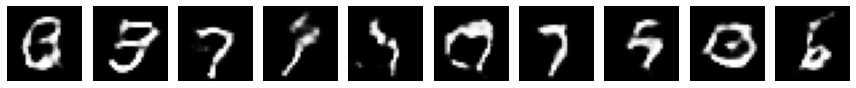

In [19]:
train(train_dataset, epochs=50, plot_frequency=5)